In [1]:
import cv2
import numpy as np
from skimage import measure, color, io
from os.path import join
import io
import pandas as pd
from skimage import img_as_ubyte, exposure
from skimage.measure import regionprops_table
import matplotlib.pyplot as plt
from utils.nucStitch import fullNucImage16
import os
import skimage
from PIL import Image
from inducedRainbow.waterShedSegmentation import watershed
from utils.visualization import plotMasks

In [45]:
imagePath = '/Volumes/Aortas/Aorta/preprocessedImages/rainbow/inducedRainbow/thresholded/red/10-21/aorta02/221111_C5RB-P5-10_0021_redThresholded8bit.tif'
nucleiPath = '/Volumes/Aortas/Aorta/segmentations/inducedRainbow/final/nuclei/10-21/aorta01'
originalImagePath = "10-21/aorta02/221111_C5RB-P5-10_0021_red.tif"
nucImagePath = "10-21/aorta02/221111_C5RB-P5-10_0021_nuclei.tif"
distTransformMultiplyer = 0.01
npy_file = "clusterSizeRedP10-21_aorta02_50Thres.npy"
cellposeFileName = "cellposeSegm_RedP10-21_aorta02_50Thres.npy"
savePath = '/Volumes/Aortas/Aorta/segmentations/inducedRainbow/old/red/10-21/aorta022'
imageSavename = 'P10-21_aorta02_red_Segmentation_Numbers_50Thres_New.tif'
npy_fileMarkers = 'markersImageRedP10-21_aorta02_50Thres_New.npy'
#origImagePath = '/Users/jones/data/luisaData/inducedRainbow/red/220802_C5RB P30-1_5-30_red.tif'

In [53]:
df = pd.DataFrame()
nuclei = np.load(join(nucleiPath, "Cropped_IMG-1_seg.npy"), allow_pickle=True).item()['masks']
yLength = nuclei.shape[0]
xLength = nuclei.shape[1]
for i in range(16):
    number = i+1
    nuclei = np.load(join(nucleiPath, "Cropped_IMG-" + str(number) + '_seg.npy'), allow_pickle=True).item()['masks']
    row = int(i/4) + 1
    column  = (i%4) + 1
    prop_dict = regionprops_table(nuclei, properties = ('label', 'centroid'))
    df_help = pd.DataFrame(prop_dict)
    df_help['picture_id'] = number
    df_help['yCoord'] = df_help['centroid-0']*row
    df_help['xCoord'] = df_help['centroid-1']*column
    #df = df.append(df_help, ignore_index=True)
    df = pd.concat([df, df_help], axis=0)

In [56]:

nucImage = fullNucImage16(nucleiPath)
nucleiFiltered = np.copy(nucImage)
markersNew = watershed(imagePath)

In [58]:
# Count nuclei in segmentation and check if nuclei is mostly in segmentation
accuracy_value = 0.5
#get rid of outlines and different backgrounds
markersAnalyse = np.copy(markersNew)
#markersAnalyse[markersAnalyse == -1] = 0
nucAnalyze = np.copy(nucleiFiltered)

clusters = list()
dic = {}
for i in np.unique(markersAnalyse):
    if (i != 0) & (i != -1):
        cluster = list()
        segmentationNuc = np.unique(nucAnalyze[np.where(markersAnalyse == i)])
        for j in segmentationNuc:
            if j != 0:
                #occurence of nucleus pixel in
                nucOccur = np.bincount(nucAnalyze[np.where(markersAnalyse == i)])[j]
                #How many pixels does this nucleus have:
                coordLen = len(np.where(nucAnalyze == j)[0])
                #check if most of nuclei values are in segmentation
                if(nucOccur >= accuracy_value*coordLen):
                    cluster.append(j)
        if cluster:
            dic[i] = cluster
            clusters.append(cluster)
        else:
            markersAnalyse[markersAnalyse == i] = 0

In [60]:
prop_dict = regionprops_table(markersAnalyse, properties = ('label', 'centroid'))
dfRainbow = pd.DataFrame(prop_dict)

In [62]:
#create a new nice image
minus1 = np.where(markersAnalyse == -1)
for i in range(len(minus1[0])):
    minus1y = minus1[0][i]
    minus1x = minus1[1][i]
    if (minus1y != 0) & (minus1y != (markersAnalyse.shape[0] -1)) & (minus1x != 0) & (minus1x != (markersAnalyse.shape[1]-1)):
        numbers = np.unique([markersAnalyse[minus1y - 1,minus1x], markersAnalyse[minus1y + 1,minus1x], markersAnalyse[minus1y,minus1x-1], markersAnalyse[minus1y,minus1x +1]])
        uniqueMasks  = set(numbers) - set([-1, 0])
        masks = list(uniqueMasks)
        if len(masks) == 0:
            markersAnalyse[minus1y,minus1x] = 0


In [63]:
img1Filtered = cv2.imread(imagePath)
img1Filtered[markersAnalyse == -1] = [0,255,255]

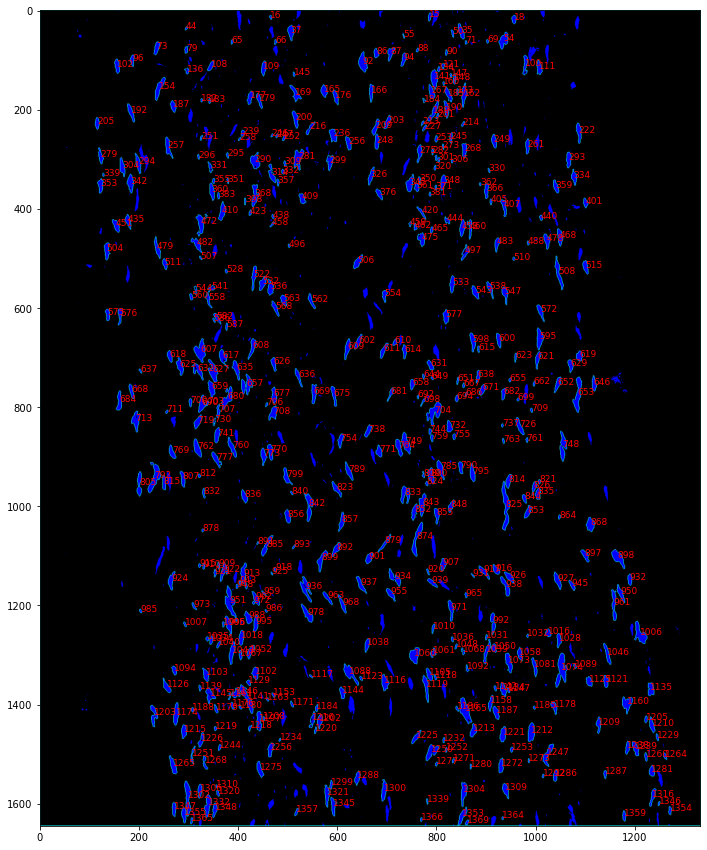

In [66]:

fig, ax = plt.subplots(figsize=(36,15))

ax.imshow(img1Filtered)
for i in range(len(dfRainbow)):
    ax.text(dfRainbow['centroid-1'][i], dfRainbow['centroid-0'][i], dfRainbow['label'][i], fontsize=9, color = 'red')
plt.show()

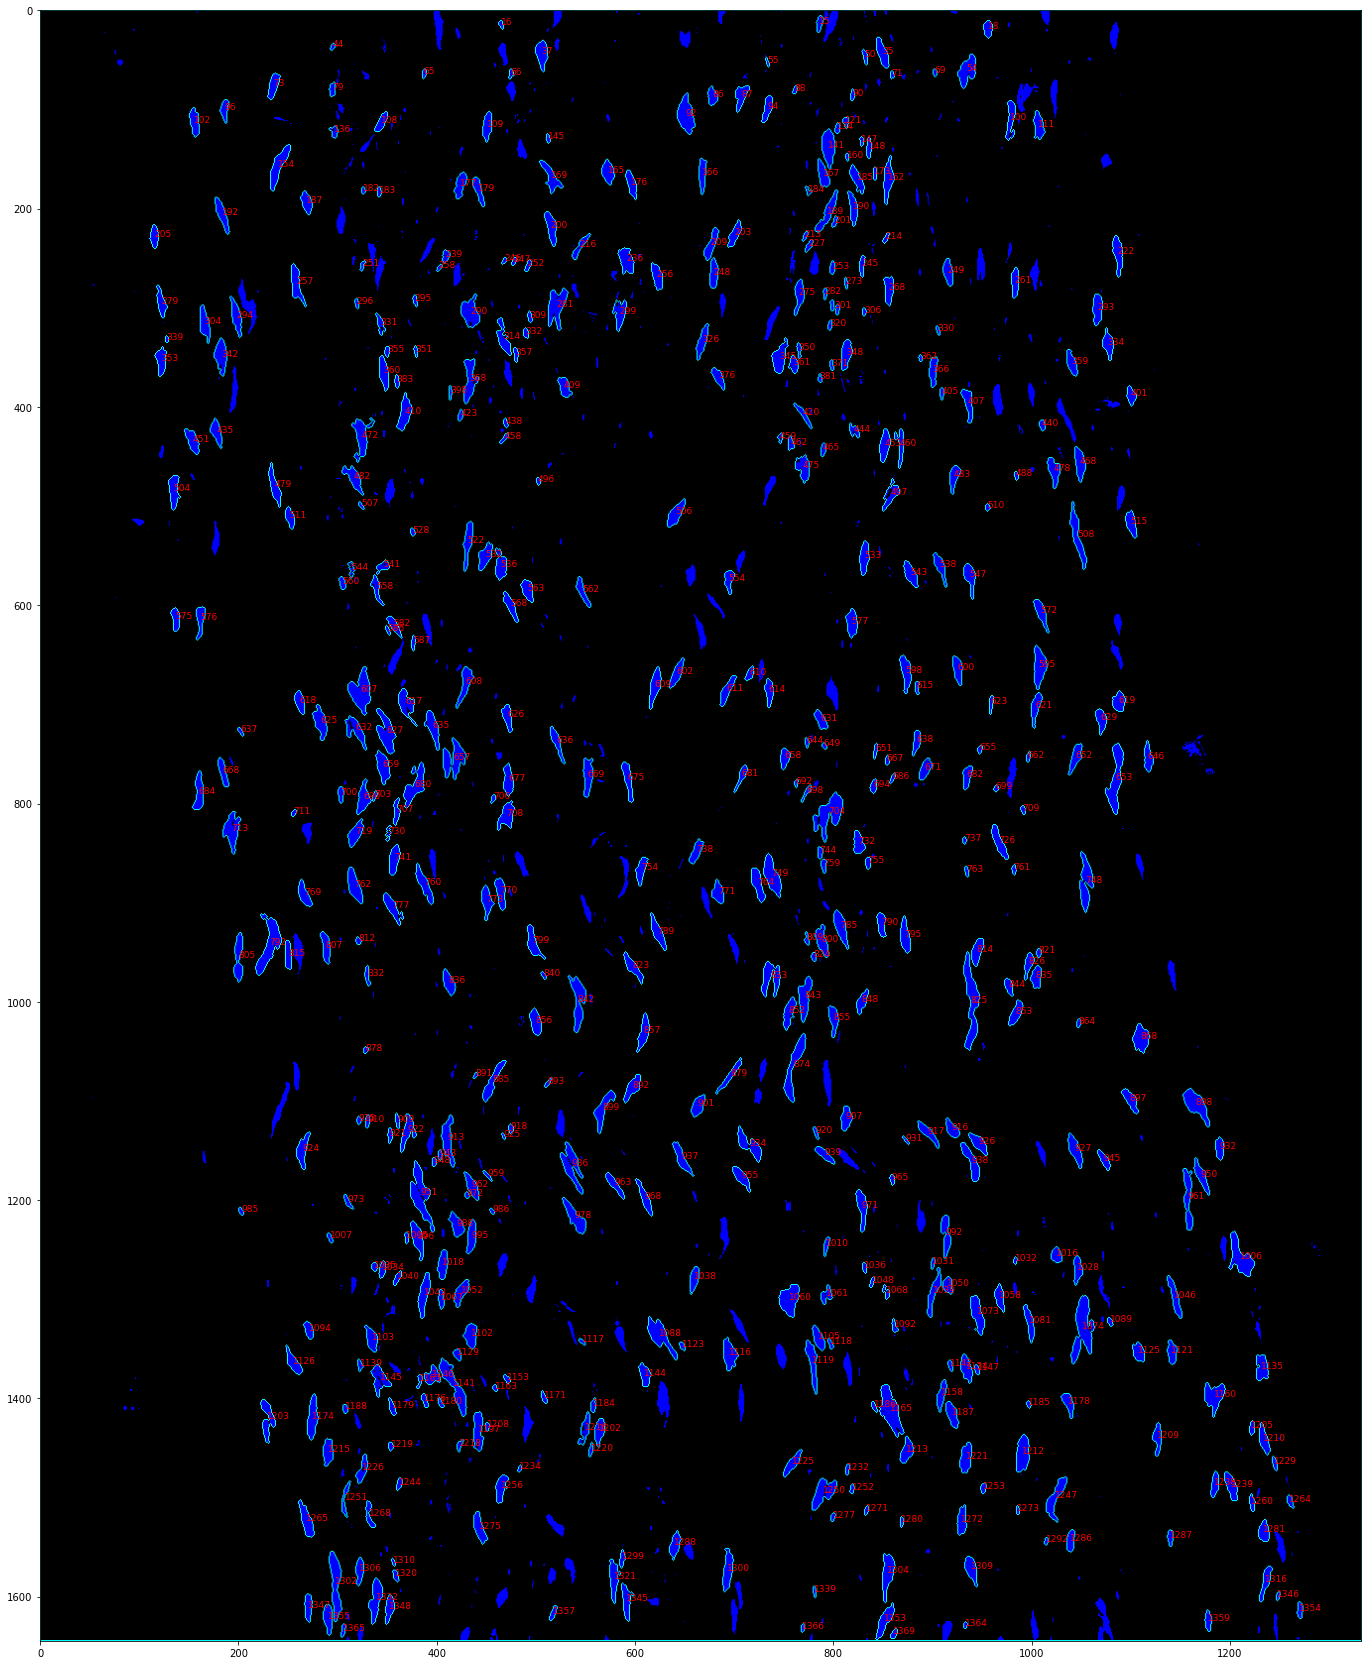

In [69]:

fig, ax = plt.subplots(figsize=(72,30))
ax.imshow(img1Filtered)
for i in range(len(dfRainbow)):
    ax.text(dfRainbow['centroid-1'][i], dfRainbow['centroid-0'][i], dfRainbow['label'][i], fontsize=9, color = 'red')

png1 = io.BytesIO()
fig.savefig(png1, format="png")
png2 = Image.open(png1)
png2.save(join(savePath, imageSavename))
png1.close()

In [70]:
os.chdir(savePath)
np.save(npy_file,  dic)

In [71]:
markersdic = {}
markersdic['image'] = markersAnalyse
np.save(npy_fileMarkers,  markersdic)

In [72]:
cellposeFile = {}
#read in image
originalImg = skimage.io.imread(join("/Volumes/Aortas/Aorta/preprocessedImages/rainbow/inducedRainbow/stitched", originalImagePath))
nucleiImg = skimage.io.imread(join("/Volumes/Aortas/Aorta/preprocessedImages/rainbow/inducedRainbow/stitched", nucImagePath))
zeros = np.zeros(originalImg.shape, dtype="uint8")
#8bit normalize & merge
dapi8bitNormalized= img_as_ubyte(exposure.rescale_intensity(nucleiImg))
rainbow8bitNormalized = img_as_ubyte(exposure.rescale_intensity(originalImg))
dapi8bitNormalized = np.asarray(dapi8bitNormalized)
dapi8bitNormalized = dapi8bitNormalized*0.1
dapi8bitNormalized = dapi8bitNormalized.astype(rainbow8bitNormalized.dtype)
merged8bitNormalized = cv2.merge([rainbow8bitNormalized, dapi8bitNormalized, zeros])
#define masks and outlines
masks = np.where(markersAnalyse==-1, 0, markersAnalyse)
outlines = np.where(markersAnalyse==-1,1,0)
#save in dic
cellposeFile['masks'] = masks
cellposeFile['img'] = merged8bitNormalized
cellposeFile['outlines'] = outlines
np.save(join(savePath, cellposeFileName),cellposeFile)